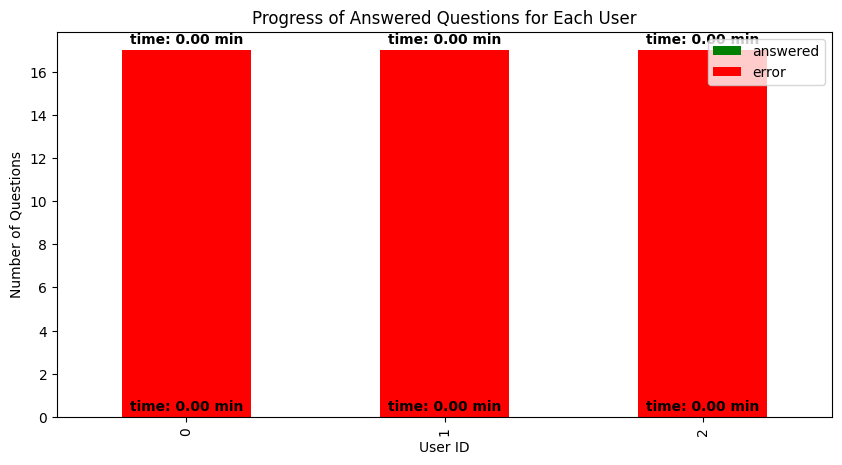

Volume testing completed with 3 users and 17 questions.
Errors occurred during volume testing. Here are the details:
Error occurred for user 0 question: What are the causes of climate change?. Error: Error raised by bedrock service: An error occurred (ExpiredTokenException) when calling the InvokeModel operation: The security token included in the request is expired
Error occurred for user 0 question: What are some interesting facts about the universe?. Error: Error raised by bedrock service: An error occurred (ExpiredTokenException) when calling the InvokeModel operation: The security token included in the request is expired
Error occurred for user 0 question: What are the different types of machine learning algorithms?. Error: Error raised by bedrock service: An error occurred (ExpiredTokenException) when calling the InvokeModel operation: The security token included in the request is expired
Error occurred for user 0 question: What is the weather like today?. Error: Error raised by 

In [4]:
import os
import tempfile
import pandas as pd
import random
import boto3
from langchain_community.llms import Bedrock
from langchain_aws import BedrockLLM
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import time
import certifi
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display, clear_output

# Set the AWS profile
os.environ["AWS_PROFILE"] = "default"
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Create a temporary directory for storing the uploaded files
temp_dir = tempfile.TemporaryDirectory()

# Function to validate the uploaded file
def validate_file(file_path):
    try:
        # Read the file using pandas
        df = pd.read_excel(file_path)
        return True, df.shape[0]
    except Exception as e:
        return False, 0

# Create the Bedrock client
bedrock_client = boto3.client(
    service_name="bedrock-runtime",
    region_name="us-east-1"
)

# Set the model ID
model_id = "meta.llama3-8b-instruct-v1:0"

# Create the Bedrock instance
llm = BedrockLLM(
    model_id=model_id,
    client=bedrock_client,
    model_kwargs={"max_gen_len": 512, "temperature": 0.5}
)

# Define the chat function
def chat(question):
    prompt = PromptTemplate(
        input_variables=["question"],
        template="{question}"
    )

    bedrock_chain = LLMChain(llm=llm, prompt=prompt)

    response = bedrock_chain({'question': question})
    return response

# Function to simulate question asking for a single user
def simulate_user_questions(user_id, questions, user_progress, user_time):
    random.shuffle(questions)  # Shuffle the questions for each user

    for question in questions:
        try:
            # Start the timer
            start_time = time.time()

            # Get the answer from the model
            response = chat(question)
            answer = response["text"]

            # Stop the timer
            end_time = time.time()
            time_taken = end_time - start_time
            user_time[user_id] += time_taken

            user_progress[user_id]["answered"] += 1  # Increment the total answered questions
        except Exception as e:
            error_info = f"Error occurred for user {user_id} question: {question}. Error: {str(e)}"
            error_log.append(error_info)
            user_progress[user_id]["error"] += 1  # Increment the total error count

# Placeholder for user input file paths
users_file_path = "users.xlsx"  # Replace with the actual path
questions_file_path = "questions.xlsx"  # Replace with the actual path

# Validate the files
is_users_valid, user_count = validate_file(users_file_path)
is_questions_valid, question_count = validate_file(questions_file_path)

error_log = []

if is_users_valid and is_questions_valid:
    # Read the user details and questions from the files
    users = pd.read_excel(users_file_path)
    questions_df = pd.read_excel(questions_file_path)

    # Check if the 'Question' column exists
    if 'Question' not in questions_df.columns:
        print("Error: The 'Question' column is not found in the questions file.")
        print(f"Available columns are: {questions_df.columns.tolist()}")
    else:
        questions = questions_df["Question"].tolist()

        user_progress = {user_id: {"answered": 0, "error": 0} for user_id in users.index}
        user_time = {user_id: 0 for user_id in users.index}

        # Start the ThreadPoolExecutor to manage parallel execution
        with ThreadPoolExecutor(max_workers=user_count) as executor:
            futures = []
            for user_id in users.index:
                # Stagger the start time for each user
                futures.append(executor.submit(simulate_user_questions, user_id, questions, user_progress, user_time))
                time.sleep(5)  # Staggered start delay

            # Wait for all futures to complete
            for future in as_completed(futures):
                future.result()

        # Create a DataFrame from the user_progress dictionary
        progress_df = pd.DataFrame(user_progress).T

        # Plot the progress for each user
        fig, ax = plt.subplots(figsize=(10, 5))  # Set a reasonable size for the plot
        progress_df.plot(kind='bar', stacked=True, color=['green', 'red'], ax=ax)
        ax.set_xlabel('User ID')
        ax.set_ylabel('Number of Questions')
        ax.set_title('Progress of Answered Questions for Each User')
        ax.yaxis.get_major_locator().set_params(integer=True)  # Ensure y-axis has integer values only

        # Display time taken on each bar
        for p in ax.patches:
            user_id = int(p.get_x() + p.get_width() / 2)
            time_text = f"time: {user_time[user_id] / 60:.2f} min"
            ax.annotate(time_text, (p.get_x() + p.get_width() / 2, p.get_height() + 0.5), 
                        ha='center', va='center', fontsize=10, color='black', fontweight='bold')

        clear_output(wait=True)
        display(fig)
        plt.close(fig)

        print(f"Volume testing completed with {user_count} users and {question_count} questions.")
        if error_log:
            print("Errors occurred during volume testing. Here are the details:")
            for error in error_log:
                print(error)
else:
    print("One or both of the uploaded files are not valid Excel files.")




